## Movie Emotion Recognition <br>

<font size="3"> Team members: </font><br>
<font size="3"> Jesse Cahill </font><br>
<font size="3"> Zhongling Jiang </font><br>
<font size="3"> Zile Wang </font>

Dataset Google Drive Link: https://drive.google.com/open?id=1_Ds_2tV4tUFiisVgDaM1utOEzEW9aSLR 
And I go to 1000songs/clips_45seconds/..<br>
Tutorial: https://musicinformationretrieval.com/#Introduction

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

%matplotlib inline

In [2]:
y, sr = librosa.load('../1000songs/examples/2.mp3')

/Users/zhonglingjiang/anaconda3/envs/musicrecommendation/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [19]:
print(y.shape)
print(sr)

(993312,)
22050


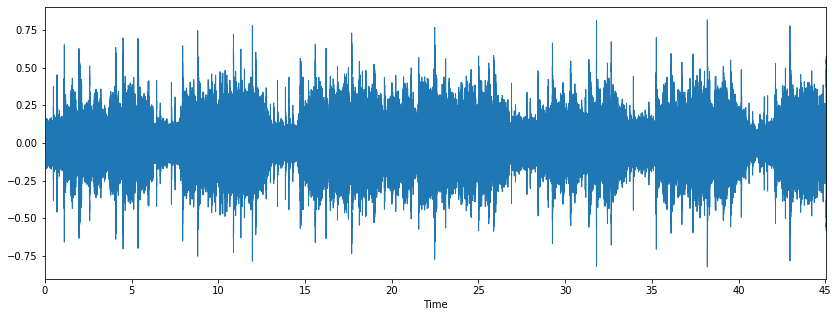

In [4]:
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

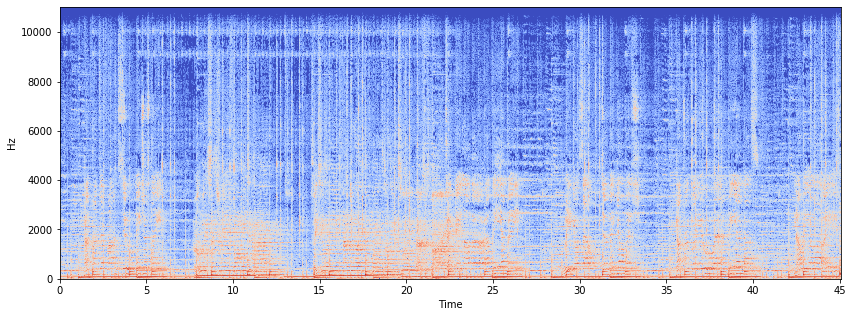

In [5]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

List of features see this link: http://mac.citi.sinica.edu.tw/~yang/pub/yang11taslp_dist.pdf <br>
Our target paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7745959

<img src="image.png" style="width: 500px;"/>


Python Librosa Library: https://librosa.github.io/librosa/

### Harmonic

The 10 harmonic
features includes the mean and standard deviation of
per-frame salient pitch, chromagram center, key clarity,
mode, harmonic change.

https://bmcfee.github.io/papers/scipy2015_librosa.pdf

<img src="image2.png" style="width: 500px;"/>

In [6]:
# Redefine hop_length, frame_length
# sr is sampling rate, i.e. # of samples taken in one second
# frame length: The (positive integer) number of samples in an analysis window (or frame). This is denoted by an integer variable n_fft.
# hop length: The number of samples between successive frames, e.g., the columns of a spectrogram. This is denoted as a positive integer hop_length
per_sample_t = 1.0 / sr
default_frame_length = 2048
default_hop_length = 512
print(default_frame_length * per_sample_t * 1000, default_hop_length * per_sample_t * 1000)

# Now adjust two lengths according to requirement in paper (NEED TO CHECK!!)
pitch_frame_length = int(50 / 1000 / per_sample_t)
pitch_hop_length = int(25 / 1000 / per_sample_t)

chromagram_frame_length = int(100 / 1000 / per_sample_t)
chromagram_hop_length = int(12.5 / 1000 / per_sample_t)



print(pitch_frame_length)

92.87981859410431 23.219954648526077
1102


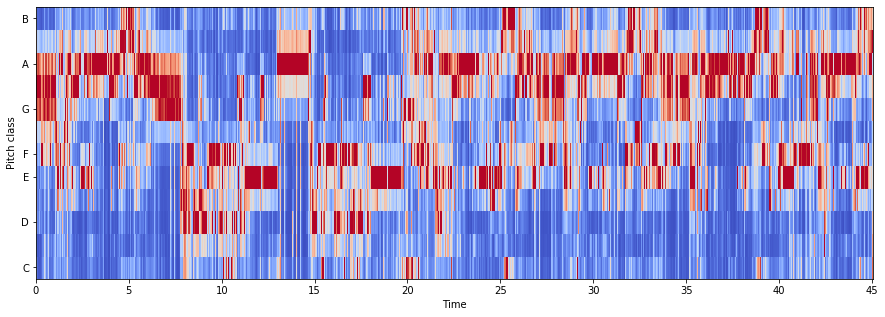

In [7]:
chromagram = librosa.feature.chroma_stft(y, sr=sr, n_fft=chromagram_frame_length, hop_length=chromagram_hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=chromagram_hop_length, cmap='coolwarm')

In [8]:
np.ceil(0.5)

1.0

In [9]:
print(len(y))
print(len(librosa.autocorrelate(y)))

993312
993312


In [10]:
# Salient Pitch
# MIR toolbox estimates the pitch, or the perceived fundamental frequency, of each short time frame (50 ms, 1/2 overlapping)
# The pitch estimate corresponding to the highest peak is returned as the salient pitch.
fft_for_all_frames = librosa.core.stft(y, n_fft=pitch_frame_length, hop_length=pitch_hop_length, window='hann')
print(fft_for_all_frames.shape[1])                 # 1102

half_frame_length = int(pitch_frame_length / 2) 

right_side_fft_all_frames = np.zeros(shape = (half_frame_length, fft_for_all_frames.shape[1]))
for h in range(half_frame_length):
    for i in range(fft_for_all_frames.shape[1]):
        right_side_fft_all_frames[h][i] = np.conjugate(fft_for_all_frames[half_frame_length - 1 - h][i])
one_khz_index = int(pitch_frame_length * 1000 / sr) # index for dividing the length x[:k] (< 1khz) x[k:] (>1khz) 
below_1khz_subband = right_side_fft_all_frames[:one_khz_index,:]
above_1khz_subband = right_side_fft_all_frames[one_khz_index:,:]

below_1khz_autocorr = np.apply_along_axis(librosa.autocorrelate, 0, below_1khz_subband)
above_1khz_autocorr = np.apply_along_axis(librosa.autocorrelate, 0, above_1khz_subband)

# below_1khz_autocorr.sum(axis=0)


# def freq_from_autocorr(sig, fs):
#     from scipy.signal import blackmanharris, correlate
#     from parabolic import parabolic
#     """
#     https://gist.github.com/endolith/255291
#     Estimate frequency using autocorrelation
#     """
#     # Calculate autocorrelation and throw away the negative lags
#     corr = correlate(sig, sig, mode='full')
#     corr = corr[len(corr)//2:]

#     # Find the first low point
#     d = diff(corr)
#     start = nonzero(d > 0)[0][0]

#     # Find the next peak after the low point (other than 0 lag).  This bit is
#     # not reliable for long signals, due to the desired peak occurring between
#     # samples, and other peaks appearing higher.
#     # Should use a weighting function to de-emphasize the peaks at longer lags.
#     peak = argmax(corr[start:]) + start
#     px, py = parabolic(corr, peak)

#     return fs / px

1803


/Users/zhonglingjiang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


In [18]:
# chromagram center
# librosa.feature.chroma_stft(y=y, sr=sr) # find center of that
# https://librosa.github.io/librosa/generated/librosa.feature.spectral_centroid.html
chromagram_center = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=chromagram_frame_length, \
                                                      hop_length=chromagram_hop_length)[0]
chromagram_center_features_count = len(chromagram_center)
print(chromagram_center_features_count)
# key clarity

# mode

# harmonic change
# The difference between the best major key and the best minor key in key strength
# MIR toolbox also utilizes the algorithm described in [69] to detect the harmonic
# changes (e.g., chord change) of a clip from its chromagram. High harmonic change indicates large difference in harmonic
# content between consecutive frames. T


3613


### Spectral
The spectral features consists of
32 spectral flatness measures, 32 spectral crest factors, and
26 Mel-scale frequency cepstral coefficients.

In [15]:
# SFM 
# https://librosa.github.io/librosa/generated/librosa.feature.spectral_flatness.html
flatness = librosa.feature.spectral_flatness(y=y, n_fft=2048, hop_length=512)
print(flatness.shape)
# MFCC # takes first 13
mfcc = librosa.feature.mfcc(y=y, sr=sr)
print(mfcc.shape)

(1, 1941)
(20, 1941)
